# ICA02 — Working with WRF output (wrfout) in Python

This notebook is a streamlined introduction to reading and plotting WRF `wrfout` files with xarray.

Julie.Lundquist@JHU.edu
2026 January 18 (updated from 2023 version)

## Learning goals
By the end, you should be able to:
1. Open a `wrfout_d0*` NetCDF file with `xarray`
2. Inspect variables/dimensions and find what you need
3. Make a quick **domain map** and a **field plot**
4. Extract a **time series** at a point and compute simple diagnostics

> **Tip:** WRF variables often have a `Time` dimension and 2D lat/lon stored in `XLAT` and `XLONG`.


In [1]:
# --- Imports ---
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


import cartopy.crs as ccrs
import cartopy.feature as cfeature

from pathlib import Path
import glob

from matplotlib.axes import Axes # Makes the color bar easier to work with
from mpl_toolkits.axes_grid1 import make_axes_locatable # Color bar location

from matplotlib.colors import ListedColormap, BoundaryNorm # Because I'm particular about color tables
from matplotlib.colors import Normalize # Because I'm particular about color tables


print("Imports OK")

Imports OK


In [2]:
# Julie is particular about color tables for terrain....

class WaterLandNormalize(Normalize):
    def __init__(self, vmin=0, vmax=3000, water_frac=0.2, clip=False):
        self.water_frac = water_frac
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        value = np.asarray(value)

        # Initialize normalized array
        result = np.zeros_like(value, dtype=float)

        # Water (HGT == 0)
        water = value <= 0
        result[water] = 0.0

        # Land (HGT > 0)
        land = value > 0
        result[land] = self.water_frac + (
            (value[land] - 0) / (self.vmax - 0)
        ) * (1.0 - self.water_frac)

        return np.ma.masked_array(result)


## 1) Point to your data

Set `DATA_DIR` to the folder containing your WRF output files (e.g., `wrfout_d01_YYYY-MM-DD_HH:MM:SS`).

If you're working on a shared system, copy the files you need into a directory you can read quickly (scratch or project space).


In [5]:
# --- Edit this path ---
DATA_DIR = Path(".")  # STUDENTS EDIT THIS Path("/path/to/your/wrfout/files")
DATA_DIR = Path("/pl/active/courses/2023_fall/ATOC_NWP/InClassAssignments/ICA_01/")

# Find candidate wrfout files
wrf_files = sorted(DATA_DIR.glob("wrfout_d0*"))  # matches wrfout_d01_...
print(f"Found {len(wrf_files)} wrfout file(s) in {DATA_DIR.resolve()}")

# If you have many files, you can pick one:
if len(wrf_files) == 0:
    raise FileNotFoundError(
        "No wrfout files found. Update DATA_DIR to the folder that contains wrfout_d0* files."
    )

WRF_FILE = wrf_files[0]
print("Using:", WRF_FILE.name)

Found 3 wrfout file(s) in /pl/active/courses/2023_fall/ATOC_NWP/InClassAssignments/ICA_01
Using: wrfout_d01_2005-08-28_00_00_00


## 2) Open the dataset with xarray

For teaching purposes we open without dask chunking. If your file is large, ask and we can switch to chunked reads.


In [7]:
ds = xr.open_dataset(WRF_FILE)

# Quick look (in Jupyter this renders nicely)
ds

<xarray.Dataset>
Dimensions:                (Time: 4, south_north: 73, west_east: 90,
                            bottom_top: 29, bottom_top_stag: 30,
                            soil_layers_stag: 4, west_east_stag: 91,
                            south_north_stag: 74)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag
Data variables: (12/140)
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float32 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    ...                     ...
    ISEEDARR_SPPT          (Time, bottom_top) int32 ...
    ISEEDARR_SKEBS         (Time, bottom_top) int32 ...
    LANDMASK               (Time, south_north, west_east) float32 ...
    LAKEMASK               (Time, south_north, west_east) float32 ...
    SST                    (Time, south_north, west_east) float32 ...
    SST_INPUT              (Time, south_north, west_east) float32 ...
Attributes: (12/116)
    TITLE:                            OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                      2005-08-28_00:00:00
    SIMULATION_START_DATE:           2005-08-28_00:00:00
    WEST-EAST_GRID_DIMENSION:        91
    SOUTH-NORTH_GRID_DIMENSION:      74
    BOTTOM-TOP_GRID_DIMENSION:       30
    ...                              ...
    NUM_LAND_CAT:                    24
    ISWATER:                         16
    ISLAKE:                          -1
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14

## 3) Inspect dimensions and variables

In [8]:
print("Dimensions:")
for k, v in ds.dims.items():
    print(f"  {k}: {v}")

# Show a short list of variables (first ~30)
vars_list = list(ds.data_vars)
print("\nData variables (first 30):")
print(vars_list[:30])

Dimensions:
  Time: 4
  south_north: 73
  west_east: 90
  bottom_top: 29
  bottom_top_stag: 30
  soil_layers_stag: 4
  west_east_stag: 91
  south_north_stag: 74

Data variables (first 30):
['Times', 'LU_INDEX', 'ZNU', 'ZNW', 'ZS', 'DZS', 'VAR_SSO', 'U', 'V', 'W', 'PH', 'PHB', 'T', 'HFX_FORCE', 'LH_FORCE', 'TSK_FORCE', 'HFX_FORCE_TEND', 'LH_FORCE_TEND', 'TSK_FORCE_TEND', 'MU', 'MUB', 'NEST_POS', 'P', 'PB', 'FNM', 'FNP', 'RDNW', 'RDN', 'DNW', 'DN']


## 4) Get lat/lon and plot the domain

WRF typically stores latitude/longitude in `XLAT` and `XLONG`. They often include a `Time` dimension, so we select `Time=0` to get a 2D array.

Cartopy gridline labels and colorbars both live outside the map axes.
The safest approach is to give the colorbar its own axis.


Map bounds [lon_min, lon_max, lat_min, lat_max]: [-101.00782775878906, -76.99217224121094, 19.10747528076172, 36.215782165527344]
[OK] Saved figure → HGT.png


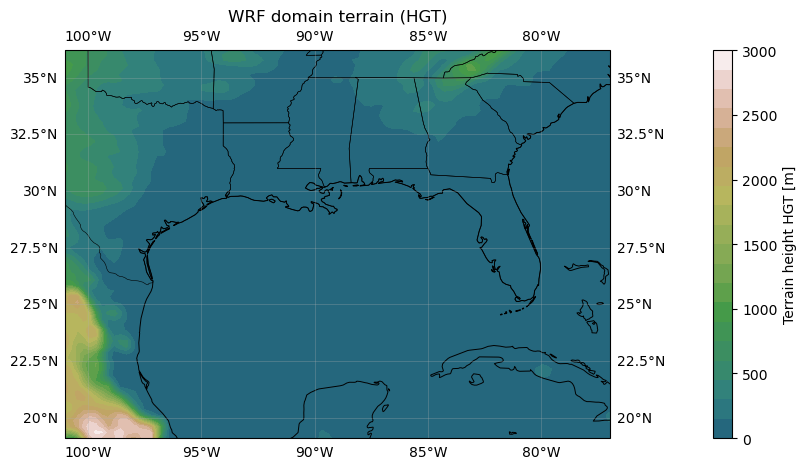

In [9]:
# 2D lat/lon for mapping
lat = ds["XLAT"].isel(Time=0)
lon = ds["XLONG"].isel(Time=0)

# Terrain height HGT (meters)
hgt = ds["HGT"].isel(Time=0)

bounds = [float(lon.min()), float(lon.max()), float(lat.min()), float(lat.max())]
print("Map bounds [lon_min, lon_max, lat_min, lat_max]:", bounds)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(9, 4.8))
ax = plt.axes(projection=proj)


ax.set_extent(bounds, crs=proj)
ax.add_feature(cfeature.LAND, facecolor="0.9")
ax.add_feature(cfeature.COASTLINE, linewidth=0.7)
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.gridlines(draw_labels=True, linewidth=0.4, alpha=0.5)

norm = WaterLandNormalize(vmin=0, vmax=3000, water_frac=0.2)

cf = ax.contourf(
    lon, lat, hgt,
    levels=20,
    cmap="gist_earth",
    norm=norm,
    transform=proj,
)


divider = make_axes_locatable(ax)

cbar = plt.colorbar(cf, ax=ax)
cbar.set_label("Terrain height HGT [m]")
cbar.set_ticks([0, 500, 1000, 1500, 2000, 2500, 3000])


ax.set_title("WRF domain terrain (HGT)")
fig.tight_layout()

save='HGT.png'
fig.savefig(save, dpi=200)
print(f"[OK] Saved figure → {save}")


plt.show()



## 5) Plot a meteorological field (example: 2-m temperature)

WRF stores 2-m temperature as `T2` (Kelvin). We'll plot the first time.


<xarray.DataArray 'Times' (Time: 4)>
array([b'2005-08-28_00:00:00', b'2005-08-28_03:00:00', b'2005-08-28_06:00:00',
       b'2005-08-28_09:00:00'], dtype='|S19')
Coordinates:
    XTIME    (Time) datetime64[ns] 2005-08-28 ... 2005-08-28T09:00:00
Dimensions without coordinates: Time
[OK] Saved figure → T2.png


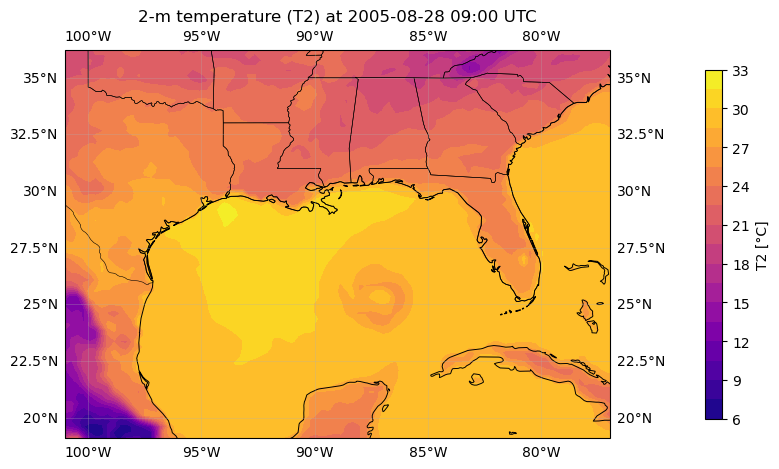

In [31]:
# Pick a time index
it = 0
it = 3

if "T2" not in ds:
    raise KeyError("T2 not found in this file. Pick another variable to plot (e.g., U10, V10, Q2, PSFC).")

t2 = ds["T2"].isel(Time=it) - 273.15  # convert K -> °C

# Format the timestamp string nicely

time_val = ds["Times"].isel(Time=it).values
# timestr_raw = time_val.decode("utf-8")  # scalar bytes case
timestr_raw = ds["Times"].isel(Time=it).astype(str).values

timestr = pd.to_datetime(timestr_raw, format="%Y-%m-%d_%H:%M:%S").strftime(
    "%Y-%m-%d %H:%M UTC"
)
print(ds["Times"])

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(9, 4.8))
ax = plt.axes(projection=proj)
ax.set_extent(bounds, crs=proj)
ax.add_feature(cfeature.COASTLINE, linewidth=0.7)
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.gridlines(draw_labels=True, linewidth=0.4, alpha=0.5)

divider = make_axes_locatable(ax)

cf = ax.contourf(lon, lat, t2, levels=21, transform=proj, cmap='plasma')
cbar = plt.colorbar(cf, ax=ax, pad=0.02, shrink=0.9)
cbar.set_label("T2 [°C]")

# ax.set_title(f"2-m temperature (T2) at Time index {it}")
ax.set_title(f"2-m temperature (T2) at {timestr}")

plt.tight_layout()

save='T2.png'
fig.savefig(save, dpi=200)
print(f"[OK] Saved figure → {save}")

plt.show()

## 6) Compute and plot a simple time series at a point

Here we compute 10-m wind speed from `U10` and `V10` at a single grid point near a chosen lat/lon.


In [11]:
# manipulate the time axis

time_index = None

if "XTIME" in ds:
    xt = ds["XTIME"].values

    # Case 1: already datetime64 (xarray decoded it)
    if np.issubdtype(xt.dtype, np.datetime64):
        time_index = pd.to_datetime(xt)

    # Case 2: numeric minutes since start (classic WRF XTIME)
    else:
        # flatten/squeeze to 1D just in case
        xt1 = np.array(xt).squeeze()
        td = pd.to_timedelta(xt1, unit="m")

        # choose a reference time:
        # prefer START_DATE if present; otherwise use an arbitrary epoch
        ref = None
        if "START_DATE" in ds.attrs:
            ref = pd.to_datetime(ds.attrs["START_DATE"], errors="coerce")
        if ref is None or pd.isna(ref):
            ref = pd.Timestamp("2000-01-01")

        time_index = ref + td

elif "Times" in ds:
    times = ds["Times"].values
    # Robust decoding for WRF char arrays:
    if times.dtype.kind in ("S", "U"):  # bytes/str
        times_str = [t.decode("utf-8") if isinstance(t, (bytes, np.bytes_)) else str(t) for t in times]
    else:
        # char array shape (Time, DateStrLen)
        times_str = ["".join(row.astype(str)) for row in times]
    time_index = pd.to_datetime([s.strip() for s in times_str], errors="coerce")

else:
    # Fallback to integer index
    time_index = np.arange(ds.sizes.get("Time", ds.dims.get("Time", 0)))


Target site: 29.95 -90.07
Nearest grid indices (j,i): 44 41
Nearest grid lat/lon: 29.88892364501953 -89.9444351196289


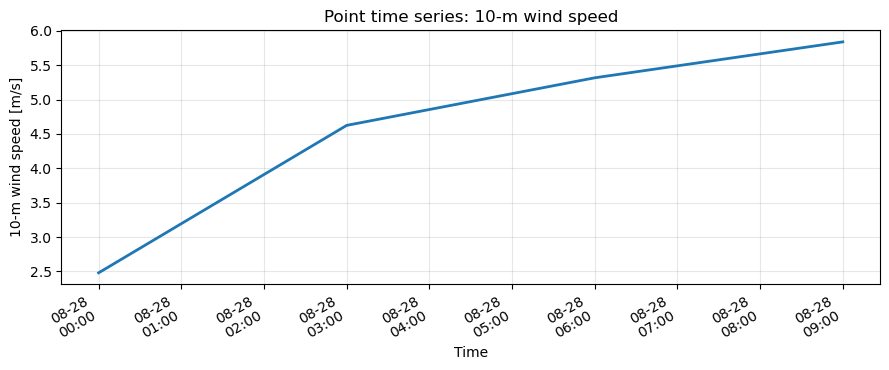

In [12]:
# Choose a site location (edit as desired)
site_lat = 29.95 # float(lat.mean())
site_lon = -90.07 # float(lon.mean())
print("Target site:", site_lat, site_lon)

# Find nearest grid point (simple squared-distance in degrees)
# Note this assumes that lat and long have similar deg --> km ratios, which is not always true
dist2 = (lat - site_lat)**2 + (lon - site_lon)**2

j, i = np.unravel_index(np.argmin(dist2.values), dist2.shape)
print("Nearest grid indices (j,i):", j, i)
print("Nearest grid lat/lon:", float(lat.values[j,i]), float(lon.values[j,i]))

# Check needed variables
for v in ["U10", "V10"]:
    if v not in ds:
        raise KeyError(f"{v} not found in this file.")

u10 = ds["U10"][:, j, i]
v10 = ds["V10"][:, j, i]
wspd10 = np.sqrt(u10**2 + v10**2)

# # Build a time coordinate (WRF often stores Times as char array)
# time_index = None
# if "XTIME" in ds:
#     # XTIME is minutes since simulation start (often)
#     time_index = pd.to_timedelta(ds["XTIME"].values, unit="m")
#     # Use an arbitrary reference just for plotting spacing
#     time_index = pd.Timestamp("2000-01-01") + time_index
# elif "Times" in ds:
#     times = ds["Times"].values
#     # Times often stored as bytes; decode
#     times_str = ["".join(t.astype(str)).strip() for t in times]
#     time_index = pd.to_datetime(times_str, errors="coerce")
# else:
#     # Fallback to integer index
#     time_index = np.arange(ds.dims["Time"])

# Plot
fig, ax = plt.subplots(figsize=(9, 3.8))
# ax.plot(time_index, wspd10, linewidth=2)
ax.plot(time_index, np.asarray(wspd10), linewidth=2)


ax.set_ylabel("10-m wind speed [m/s]")
ax.set_xlabel("Time")
ax.set_title("Point time series: 10-m wind speed")

# If datetime-like, format ticks
if isinstance(time_index, (pd.DatetimeIndex, pd.Series)) or np.issubdtype(np.asarray(time_index).dtype, np.datetime64):
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d\n%H:%M"))
    fig.autofmt_xdate()

# if isinstance(time_index, (pd.DatetimeIndex, np.ndarray)) and hasattr(time_index, "dtype") and "datetime64" in str(time_index.dtype):
#     ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d\n%H:%M"))
#     fig.autofmt_xdate()

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7) Can you do these?

1. Change the variable plotted in Section 5 to one of: `Q2`, `PSFC`, `U10`, `V10`.
2. Make a map of **10-m wind speed**: `sqrt(U10^2 + V10^2)`.
3. Pick a site (lat/lon) of your choice and plot a time series of `T2` there.
4. Plot a vertical profile at one time of `T` or `QVAPOR` at a point. What dimensions do you need?
